In [1]:
import pandas as pd
import numpy as np
import skopt
import skopt.plots

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer

In [4]:
from datetime import datetime

# Data preparation

In [5]:
df = pd.read_csv("data/German_rentals_model_input.csv")

In [6]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
drop_cols = ['base_rent', 'service_charge', 'total_rent', 'heating_costs']
X = df.select_dtypes(include=numerics)
X.drop(columns = drop_cols, inplace=True)

In [7]:
y=df.total_rent

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_test.reset_index(drop=True,inplace=True)
X_train.reset_index(drop=True,inplace=True)

# Initial model

In [10]:
rfr = RandomForestRegressor(verbose=False, n_estimators=100, max_depth=5, max_features=20)

In [11]:
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features=20, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=False, warm_start=False)

In [12]:
rfr.score(X_train, y_train)

0.797120558240702

In [13]:
rfr.score(X_test, y_test)

0.7992770834956733

# Random Forest Hyper parameter optimization

In [14]:
class Params_Evaluate():
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test =  X_test
        self.y_train = y_train
        self.y_test = y_test
        self.n=0
        
    def select_model(self, model):
        self.model = model

        
    def evaluate_params(self,params):
        model =  self.model.set_params(**params)
        model.fit(self.X_train, self.y_train)
        
        rmse_train = calculate_rmse(model, self.X_train, self.y_train)
        rmse_test = calculate_rmse(model, self.X_test, self.y_test)
        
        print("Iteration {} with RMSE = {:.1f}/{:.1f} (test/train) at {}".format(self.n, rmse_test, rmse_train, str(datetime.now().time())[:8]))
        self.n+=1
        
        return(rmse_test)
        

In [15]:
def calculate_rmse(model, X, y):
    y_hat = model.predict(X)
    y_true = y
    rmse = np.sqrt(((y_true.values - y_hat)**2).mean())
    return(rmse)
    


In [16]:
search_space = [
         skopt.space.Integer(4, 12, name='max_depth'),
         skopt.space.Integer(50, 200, name='n_estimators'),
         skopt.space.Integer(5, 20, name='max_features'),
         skopt.space.Real(0.0, 1.0, name='min_impurity_decrease'),
         skopt.space.Categorical(categories = [True, False],name="bootstrap")
         ]

In [17]:

HPO_params = {
              'n_calls':100,
              'n_random_starts':20,
              'base_estimator':'ET',
              'acq_func':'EI',
             }


In [18]:
evaluator = Params_Evaluate(X_train, X_test, y_train, y_test)

In [19]:
model = RandomForestRegressor(n_jobs=4)

In [20]:
evaluator.select_model(model)

In [21]:
@skopt.utils.use_named_args(search_space)
def objective(**params):
    return  evaluator.evaluate_params(params)

In [22]:
%%time
results = skopt.forest_minimize(objective, search_space,**HPO_params)

Iteration 0 with RMSE = 142.3/140.7 (test/train) at 14:58:51
Iteration 1 with RMSE = 134.9/126.5 (test/train) at 14:59:09
Iteration 2 with RMSE = 149.4/147.2 (test/train) at 14:59:22
Iteration 3 with RMSE = 139.9/134.2 (test/train) at 14:59:39
Iteration 4 with RMSE = 135.5/127.9 (test/train) at 15:00:16
Iteration 5 with RMSE = 152.6/150.8 (test/train) at 15:00:28
Iteration 6 with RMSE = 147.3/146.2 (test/train) at 15:00:52
Iteration 7 with RMSE = 135.0/125.4 (test/train) at 15:01:47
Iteration 8 with RMSE = 155.5/155.9 (test/train) at 15:02:15
Iteration 9 with RMSE = 163.4/163.4 (test/train) at 15:02:28
Iteration 10 with RMSE = 175.8/176.8 (test/train) at 15:02:35
Iteration 11 with RMSE = 161.8/161.3 (test/train) at 15:02:55
Iteration 12 with RMSE = 151.9/150.8 (test/train) at 15:03:09
Iteration 13 with RMSE = 136.8/130.9 (test/train) at 15:03:23
Iteration 14 with RMSE = 184.1/185.1 (test/train) at 15:03:38
Iteration 15 with RMSE = 186.9/188.2 (test/train) at 15:03:47
Iteration 16 with 

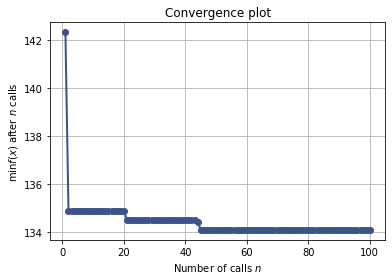

In [23]:

skopt.plots.plot_convergence(results)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AF844B0A20>,
      dtype=object)

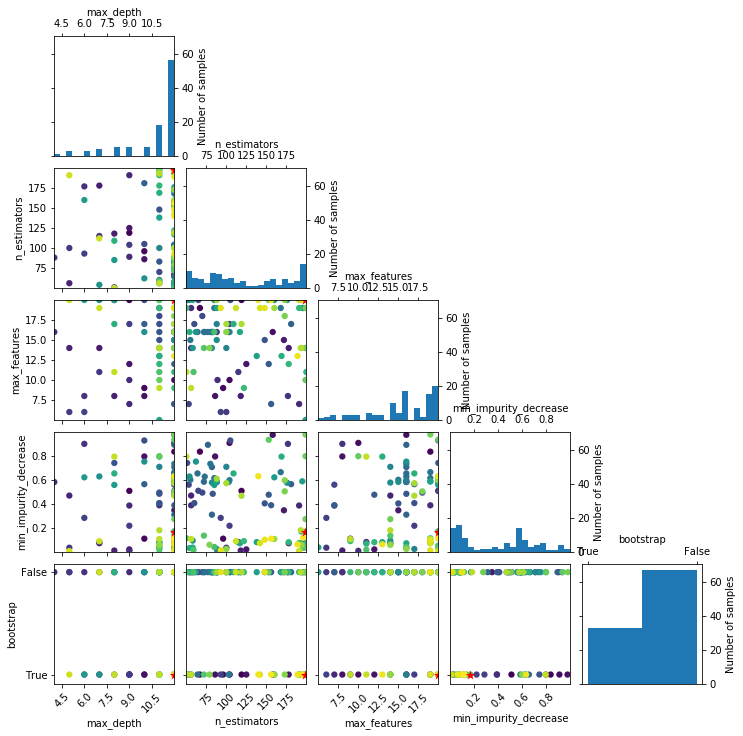

In [24]:
skopt.plots.plot_evaluations(results)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AF84CB7B38>,
      dtype=object)

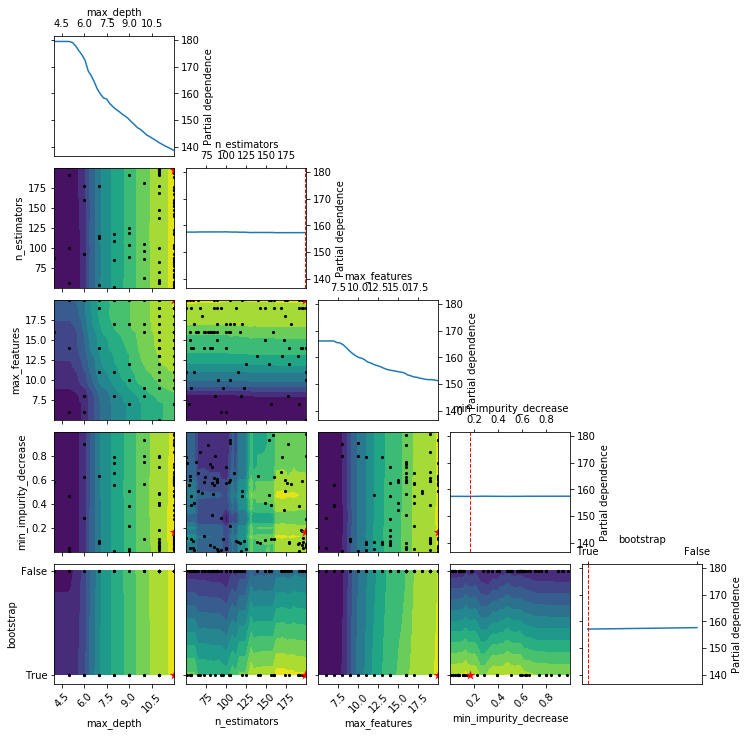

In [25]:
skopt.plots.plot_objective(results)

In [26]:
def to_named_params(results, search_space):
    params = results.x
    param_dict = {}
    params_list  =[(dimension.name, param) for dimension, param in zip(search_space, params)]
    for item in params_list:
        param_dict[item[0]] = item[1]
    
    return(param_dict)

In [27]:
best_params = to_named_params(results, search_space)

In [28]:
best_params 

{'max_depth': 12,
 'n_estimators': 198,
 'max_features': 20,
 'min_impurity_decrease': 0.1671377453940818,
 'bootstrap': True}

In [29]:
best_model = model.set_params(**best_params )

In [30]:
best_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features=20, max_leaf_nodes=None,
                      max_samples=None,
                      min_impurity_decrease=0.1671377453940818,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=198, n_jobs=4, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [31]:
best_model.score(X_train, y_train)

0.890803972468144

In [32]:
best_model.score(X_test, y_test)

0.8728466042943482

# XGBoost

## Basic model

In [33]:
from xgboost import XGBRegressor

In [34]:
model_xgb = XGBRegressor()

In [35]:
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [36]:
model_xgb.score(X_train, y_train)

0.8958937819813104

In [37]:
model_xgb.score(X_test, y_test)

0.8848247828987659

## Retooling HPO for XGBoost

In [38]:
search_space_xgb= [
         skopt.space.Integer(4, 12, name='max_depth'),
         skopt.space.Real(0.0, 1.0, name='eta'),
         skopt.space.Real(0.0, 1.0, name='subsample'),
         skopt.space.Categorical(categories = ["gbtree", "dart"],name="booster")
         ]

In [39]:
@skopt.utils.use_named_args(search_space_xgb)
def objective(**params):
    return  evaluator.evaluate_params(params)

In [40]:
evaluator = Params_Evaluate(X_train, X_test, y_train, y_test)

In [41]:
evaluator.select_model(model_xgb)

In [ ]:
%%time
results_xgb = skopt.forest_minimize(objective, search_space_xgb,**HPO_params)

Iteration 0 with RMSE = 133.2/132.1 (test/train) at 15:54:51
Iteration 1 with RMSE = 132.6/129.5 (test/train) at 15:55:05
Iteration 2 with RMSE = 140.7/139.1 (test/train) at 15:56:30
Iteration 3 with RMSE = 129.8/126.7 (test/train) at 15:57:55
Iteration 4 with RMSE = 133.8/132.7 (test/train) at 15:59:23
Iteration 5 with RMSE = 133.3/132.2 (test/train) at 15:59:35
Iteration 6 with RMSE = 132.9/129.7 (test/train) at 16:00:56
Iteration 7 with RMSE = 133.9/132.7 (test/train) at 16:01:10
Iteration 8 with RMSE = 133.4/132.4 (test/train) at 16:02:30
Iteration 9 with RMSE = 133.2/132.0 (test/train) at 16:04:03
Iteration 10 with RMSE = 132.9/131.6 (test/train) at 16:05:27
Iteration 11 with RMSE = 130.4/126.9 (test/train) at 16:06:53
Iteration 12 with RMSE = 133.8/132.8 (test/train) at 16:07:06
Iteration 13 with RMSE = 138.8/138.5 (test/train) at 16:08:21
Iteration 14 with RMSE = 134.1/132.8 (test/train) at 16:09:39
Iteration 15 with RMSE = 133.4/130.9 (test/train) at 16:11:01
Iteration 16 with 

In [ ]:
best_params_gxb = to_named_params(results_xgb, search_space_xgb)

In [ ]:
best_model = model_xgb.set_params(**best_params_gxb )

In [ ]:
best_model.score(X_train, y_train)

In [ ]:
best_model.score(X_test, y_test)

In [ ]:
skopt.plots.plot_convergence(results_xgb)